In [1]:
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from rich import print
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    PrecisionRecallDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

%load_ext rich
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/spotify_songs_train.csv")

In [3]:
def drop_month_day_null(X):
    X["track_album_release_date"] = pd.to_datetime(
        X["track_album_release_date"], errors="coerce"
    )

    not_null_mask = (
        X["track_album_release_date"].dt.month.notnull()
        & X["track_album_release_date"].dt.day.notnull()
    )

    X = X[not_null_mask]

    return X

In [4]:
data = data.dropna()

data = drop_month_day_null(data)

In [5]:
X = data.drop(columns=["track_popularity"])
y = (data["track_popularity"] > 50).astype(int)

y


0        1
1        1
2        1
3        1
4        1
        ..
29544    0
29546    0
29547    0
29548    0
29549    0
Name: track_popularity, Length: 27837, dtype: int32

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 22269

Test set size: 5568

## Feature engineering


In [7]:
class TopArtistTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_artists=10):
        self.num_top_artists = num_top_artists
        self.top_artists = None

    def fit(self, X, y=None):
        X["release_date__year"] = pd.to_datetime(
            X["track_album_release_date"], errors="coerce"
        ).dt.year
        songs_last_decade = X[
            X["release_date__year"] >= X["release_date__year"].max() - 10
        ]

        top_artists = (
            songs_last_decade.groupby("track_artist")
            .agg({"track_id": "count"})
            .rename(
                columns={
                    "track_id": "number_of_tracks",
                }
            )
        )

        top_artists = top_artists.sort_values(
            ["number_of_tracks"], ascending=[False]
        ).head(self.num_top_artists)

        self.top_artists = top_artists.index

        return self

    def transform(self, X):
        is_top_artist = X["track_artist"].isin(self.top_artists)
        return is_top_artist.to_frame(name="is_top_artist")

    def get_feature_names_out(self, input_features=None):
        return ["is_top_artist"]

In [8]:
def get_num_playlists(X):
    num_playlist = X.groupby("track_id")["playlist_id"].transform("nunique").values

    return np.column_stack([num_playlist])


def playlist_name(X, feature_names):
    return ["num_playlists"]


def release_date(X):
    X = pd.to_datetime(X, errors="coerce")

    month = X.dt.month
    day = X.dt.day

    month_season = month.map(
        {
            1: "Winter",
            2: "Winter",
            3: "Spring",
            4: "Spring",
            5: "Spring",
            6: "Summer",
            7: "Summer",
            8: "Summer",
            9: "Fall",
            10: "Fall",
            11: "Fall",
            12: "Winter",
        }
    )

    day_category = day.apply(
        lambda x: "First 10" if x <= 10 else ("Middle 10" if x <= 20 else "Last 10")
    )

    return np.column_stack([month_season, day_category])


def release_date_name(X, feature_names):
    return ["month_season", "day_category"]


def get_is_remix_or_collab(X):
    is_remix = X.str.contains("remix", case=False).astype(int)
    is_collab = X.str.contains(r"(feat|ft\.|\(with)", case=False).astype(int)
    return np.column_stack([is_remix, is_collab])


def is_remix_or_collab_name(X, feature_names):
    return ["is_remix", "is_collab"]


def get_is_weekend(X):
    X = pd.to_datetime(X, errors="coerce")
    return X.dt.dayofweek.isin([5, 6]).astype(int).values.reshape(-1, 1)


def is_weekend_name(X, feature_names):
    return ["is_weekend"]


num_playlist_pipeline = make_pipeline(
    FunctionTransformer(
        get_num_playlists,
        validate=False,
        feature_names_out=playlist_name,
    ),
    StandardScaler(),
)

release_date_pipeline = make_pipeline(
    FunctionTransformer(
        release_date, validate=False, feature_names_out=release_date_name
    ),
    OneHotEncoder(handle_unknown="ignore"),
)

num_pipeline = make_pipeline(
    StandardScaler(),
)


feature_engineering = ColumnTransformer(
    [
        (
            "num_playlists",
            num_playlist_pipeline,
            ["track_id", "playlist_id"],
        ),
        (
            "release_date",
            release_date_pipeline,
            "track_album_release_date",
        ),
        (
            "release_day",
            FunctionTransformer(
                get_is_weekend, validate=False, feature_names_out=is_weekend_name
            ),
            "track_album_release_date",
        ),
        (
            "top_artist",
            TopArtistTransformer(num_top_artists=50),
            [
                "track_artist",
                "track_album_release_date",
                "track_id",
            ],
        ),
        (
            "genres",
            OneHotEncoder(handle_unknown="ignore"),
            ["playlist_genre", "playlist_subgenre"],
        ),
        (
            "track_name",
            FunctionTransformer(
                get_is_remix_or_collab,
                validate=False,
                feature_names_out=is_remix_or_collab_name,
            ),
            "track_name",
        ),
        (
            "numerical",
            num_pipeline,
            [
                "danceability",
                "energy",
                "loudness",
                "speechiness",
                "acousticness",
                "instrumentalness",
                "liveness",
                "valence",
                "tempo",
                "duration_ms",
            ],
        ),
        (
            "key",
            OrdinalEncoder(),
            ["key"],
        ),
        ("mode", "passthrough", ["mode"]),
    ],
    remainder="drop",
)

## Model building


In [9]:
estimators = [
    ("knn", KNeighborsClassifier(weights="distance", n_neighbors=10, algorithm="auto")),
    (
        "rf",
        RandomForestClassifier(
            n_estimators=400, min_samples_split=2, max_depth=30, random_state=42
        ),
    ),
    ("gnb", GaussianNB(var_smoothing=1e-09)),
    (
        "gbc",
        GradientBoostingClassifier(
            n_estimators=300, max_depth=7, learning_rate=0.2, random_state=42
        ),
    ),
    (
        "dt",
        DecisionTreeClassifier(
            min_samples_split=5, min_samples_leaf=1, max_depth=10, random_state=42
        ),
    ),
    (
        "lgb",
        LGBMClassifier(
            learning_rate=0.5, max_depth=10, n_estimators=1000, random_state=42
        ),
    ),
    ("xgb", XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=1000)),
]

final_estimator = LogisticRegression(random_state=42)

stacked_model = StackingClassifier(
    estimators=estimators, final_estimator=final_estimator, n_jobs=-1, verbose=2, cv=5
)

stacked_model

StackingClassifier(cv=5,
                   estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=10,
                                                     weights='distance')),
                               ('rf',
                                RandomForestClassifier(max_depth=30,
                                                       n_estimators=400,
                                                       random_state=42)),
                               ('gnb', GaussianNB()),
                               ('gbc',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=7,
                                                           n_estimators=300,
                                                           random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=10,
                                                       min_samples...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=1000, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression(), n_jobs=-1, verbose=2)

In [10]:
pipeline = make_pipeline(feature_engineering, stacked_model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_playlists',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function playlist_name at 0x00000232802AF7F0>,
                                                                                       func=<function get_num_playlists at 0x00000232802AF760>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['track_id', 'playlist_id']),
                                                 ('release_date',
                                                  Pipeli...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, verbose=2))])

In [11]:
print(pipeline)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_playlists',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function 
playlist_name at 0x00000232802AF7F0>,
                                                                                       func=<function 
get_num_playlists at 0x00000232802AF760>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['track_id', 'playlist_id']),
                                                 ('release_date',
                                                  Pipeli...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, verbose=2))])

In [12]:
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

print("Model trained in {:.2f} seconds".format(end_time - start_time))
pipeline

Model trained in 212.07 seconds

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_playlists',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function playlist_name at 0x00000232802AF7F0>,
                                                                                       func=<function get_num_playlists at 0x00000232802AF760>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['track_id', 'playlist_id']),
                                                 ('release_date',
                                                  Pipeli...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=7,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=1000,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=None, ...))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1, verbose=2))])

In [13]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.72      0.84      0.78      3231
           1       0.72      0.55      0.62      2337

    accuracy                           0.72      5568
   macro avg       0.72      0.70      0.70      5568
weighted avg       0.72      0.72      0.71      5568

In [14]:
print("Performance on validation set:")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

Performance on validation set:

Accuracy: 0.7207255747126436

Precision: 0.716500553709856

Recall: 0.553701326486949

F1: 0.62466811489259

ROC AUC: 0.6976182274650777

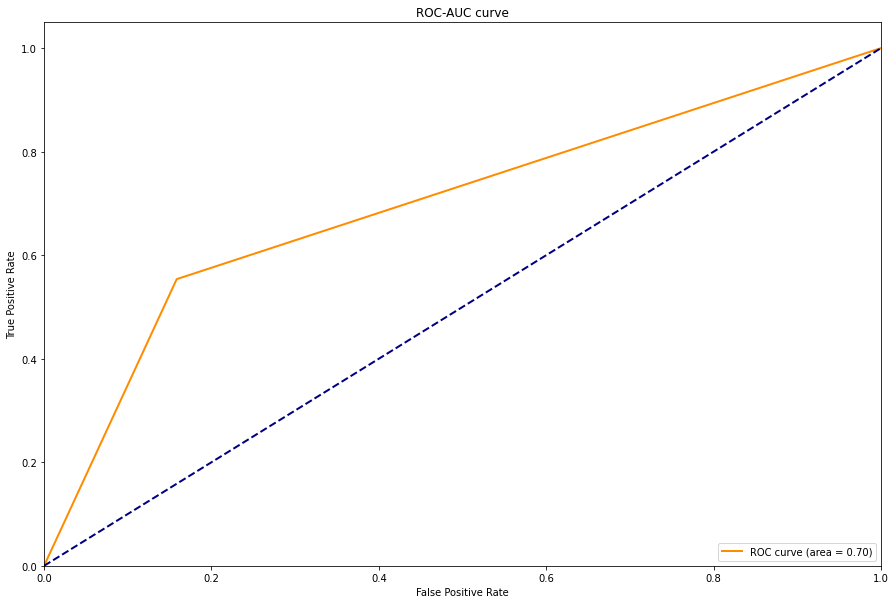

In [15]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 10))
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC curve")
plt.legend(loc="lower right")

plt.savefig("../plots/roc_auc_curve.png", dpi=300, bbox_inches="tight")

plt.show()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


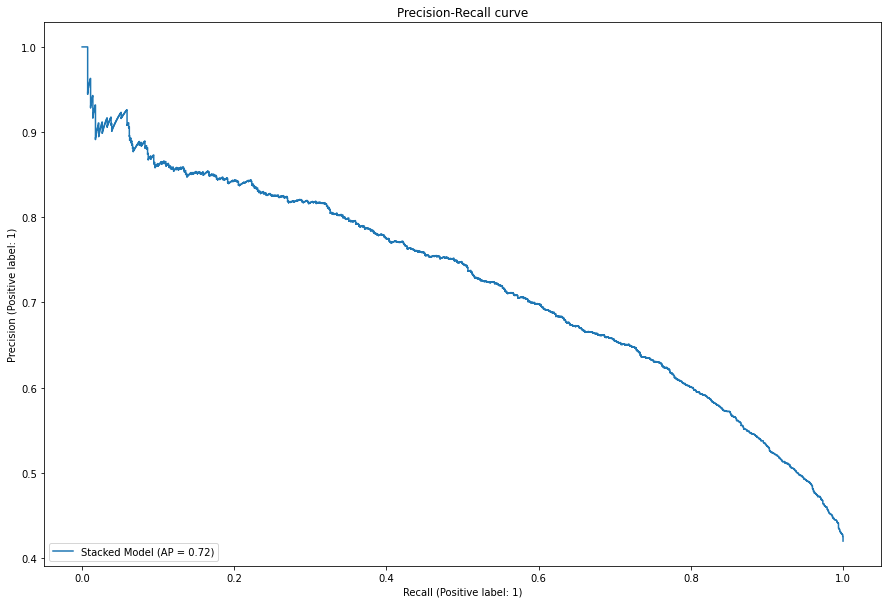

In [16]:
# Plot Precision-Recall curve
pr_curve = PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name="Stacked Model"
)

_ = pr_curve.ax_.set_title("Precision-Recall curve")
_ = pr_curve.figure_.set_size_inches(15, 10)

pr_curve.figure_.savefig(
    "../plots/precision_recall_curve.png", dpi=300, bbox_inches="tight"
)

## Performance on unseen data


In [17]:
test_data = pd.read_csv("../data/spotify_songs_isolated_sample.csv")
test_X, test_Y = (
    test_data.drop(columns=["track_popularity"]),
    (test_data["track_popularity"] > 50).astype(int),
)

test_Y_pred = pipeline.predict(test_X)

print(classification_report(test_Y, test_Y_pred))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.71      0.86      0.78      1882
           1       0.74      0.54      0.62      1401

    accuracy                           0.72      3283
   macro avg       0.73      0.70      0.70      3283
weighted avg       0.73      0.72      0.71      3283

In [18]:
print("Performance on test set:")
print(f"Accuracy: {accuracy_score(test_Y, test_Y_pred)}")
print(f"Precision: {precision_score(test_Y, test_Y_pred)}")
print(f"Recall: {recall_score(test_Y, test_Y_pred)}")
print(f"F1: {f1_score(test_Y, test_Y_pred)}")
print(f"ROC AUC: {roc_auc_score(test_Y, test_Y_pred)}")

Performance on test set:

Accuracy: 0.7225098994821809

Precision: 0.7397260273972602

Recall: 0.5396145610278372

F1: 0.6240198101527032

ROC AUC: 0.6991377799825691

## Model comparison


In [20]:
stacked_model_estimators = stacked_model.estimators_
reports = {}

X_test_transformed = pipeline.named_steps["columntransformer"].transform(X_test)


for estimator in stacked_model_estimators:
    print(f"Report for: {estimator.__class__.__name__}")

    y_pred = estimator.predict(X_test_transformed)

    print(classification_report(y_test, y_pred))

    report = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
    }

    reports[estimator.__class__.__name__] = report

Report for: KNeighborsClassifier

precision    recall  f1-score   support

           0       0.68      0.81      0.74      3231
           1       0.64      0.46      0.53      2337

    accuracy                           0.67      5568
   macro avg       0.66      0.64      0.64      5568
weighted avg       0.66      0.67      0.65      5568

Report for: RandomForestClassifier

precision    recall  f1-score   support

           0       0.71      0.86      0.78      3231
           1       0.72      0.51      0.60      2337

    accuracy                           0.71      5568
   macro avg       0.71      0.68      0.69      5568
weighted avg       0.71      0.71      0.70      5568

Report for: GaussianNB

precision    recall  f1-score   support

           0       0.72      0.68      0.70      3231
           1       0.59      0.64      0.61      2337

    accuracy                           0.66      5568
   macro avg       0.66      0.66      0.66      5568
weighted avg       0.67      0.66      0.66      5568

Report for: GradientBoostingClassifier

precision    recall  f1-score   support

           0       0.72      0.81      0.76      3231
           1       0.68      0.55      0.61      2337

    accuracy                           0.70      5568
   macro avg       0.70      0.68      0.69      5568
weighted avg       0.70      0.70      0.70      5568

Report for: DecisionTreeClassifier

precision    recall  f1-score   support

           0       0.64      0.92      0.75      3231
           1       0.70      0.28      0.40      2337

    accuracy                           0.65      5568
   macro avg       0.67      0.60      0.57      5568
weighted avg       0.66      0.65      0.60      5568

Report for: LGBMClassifier

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


precision    recall  f1-score   support

           0       0.73      0.81      0.77      3231
           1       0.69      0.58      0.63      2337

    accuracy                           0.71      5568
   macro avg       0.71      0.70      0.70      5568
weighted avg       0.71      0.71      0.71      5568

Report for: XGBClassifier

precision    recall  f1-score   support

           0       0.72      0.82      0.77      3231
           1       0.69      0.57      0.63      2337

    accuracy                           0.71      5568
   macro avg       0.71      0.69      0.70      5568
weighted avg       0.71      0.71      0.71      5568

In [21]:
y_pred_stacked = pipeline.predict(X_test)

reports["stacked_model"] = {
    "accuracy": accuracy_score(y_test, y_pred_stacked),
    "precision": precision_score(y_test, y_pred_stacked),
    "recall": recall_score(y_test, y_pred_stacked),
    "f1": f1_score(y_test, y_pred_stacked),
    "roc_auc": roc_auc_score(y_test, y_pred_stacked),
    "confusion_matrix": confusion_matrix(y_test, y_pred_stacked),
}

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [22]:
reports = pd.DataFrame(reports).T

In [23]:
reports

,accuracy,precision,recall,f1,roc_auc,confusion_matrix
KNeighborsClassifier,0.66505,0.641317,0.45828,0.534565,0.636444,"[[2632, 599], [1266, 1071]]"
RandomForestClassifier,0.711207,0.720775,0.5092,0.59679,0.68326,"[[2770, 461], [1147, 1190]]"
GaussianNB,0.662536,0.590442,0.639709,0.614089,0.659378,"[[2194, 1037], [842, 1495]]"
GradientBoostingClassifier,0.704023,0.68103,0.554557,0.611321,0.683345,"[[2624, 607], [1041, 1296]]"
DecisionTreeClassifier,0.64727,0.703381,0.275995,0.396435,0.595905,"[[2959, 272], [1692, 645]]"
LGBMClassifier,0.713003,0.685213,0.584938,0.631117,0.695285,"[[2603, 628], [970, 1367]]"
XGBClassifier,0.713901,0.694561,0.56825,0.625088,0.69375,"[[2647, 584], [1009, 1328]]"
stacked_model,0.720726,0.716501,0.553701,0.624668,0.697618,"[[2719, 512], [1043, 1294]]"


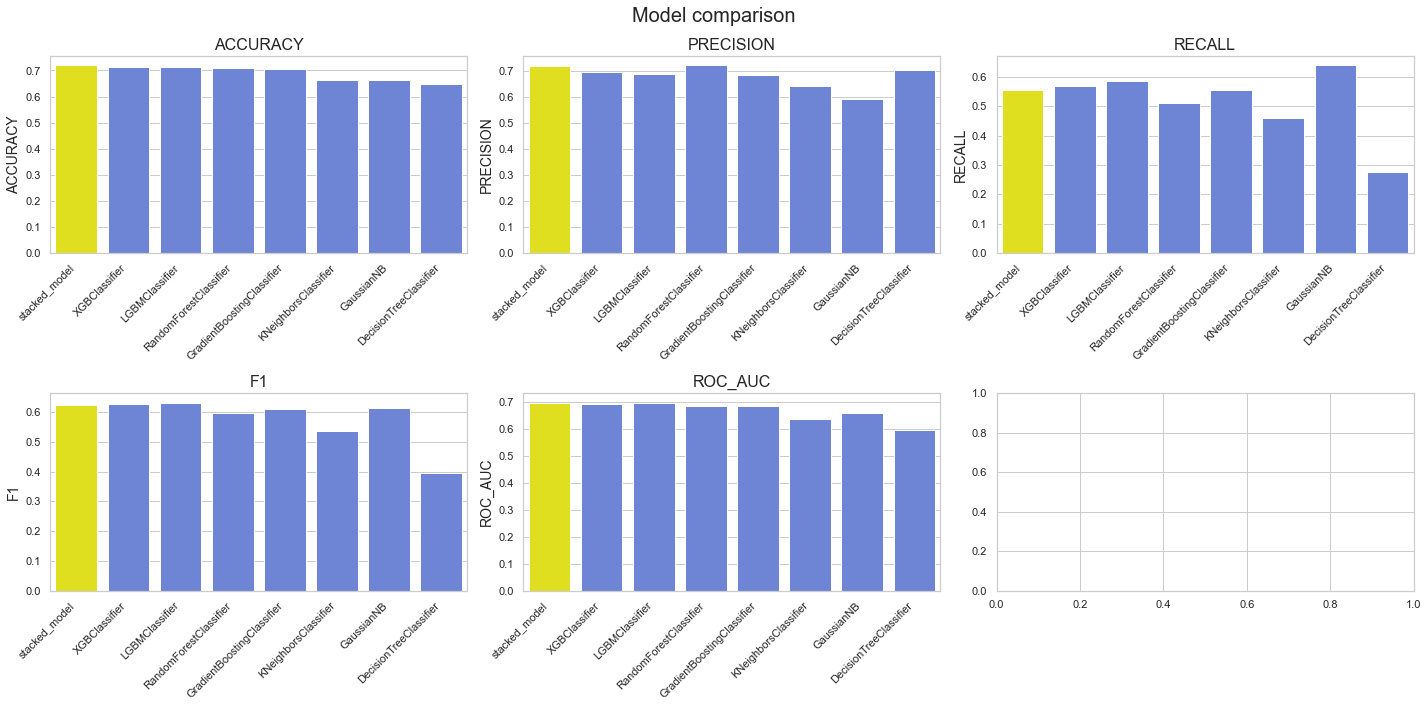

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()[:-1]  # Use only 5 subplots, ignore the last one

# Determine the order of x labels based on the first metric to ensure consistency across all plots
sorted_index = reports["accuracy"].sort_values(ascending=False).index

# Define a color palette
# Use a single color for all but the stacked_model, which will be highlighted in a different color
base_color = sns.color_palette("coolwarm", len(sorted_index))[
    0
]  # Use the first color for all
highlight_color = "yellow"  # Highlight color for the stacked_model
palette = [
    highlight_color if model == "stacked_model" else base_color
    for model in sorted_index
]

# Plot each metric for each model
for i, metric in enumerate(["accuracy", "precision", "recall", "f1", "roc_auc"]):
    sns.barplot(
        x=sorted_index, y=reports.loc[sorted_index, metric], ax=axs[i], palette=palette
    )
    axs[i].set_title(metric.upper(), fontsize=16)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha="right")
    axs[i].set_ylabel(metric.upper(), fontsize=14)
    axs[i].set_xlabel("")

# Adjust layout and add a tight layout to manage space
plt.suptitle("Model comparison", fontsize=20)
plt.tight_layout()

plt.savefig("../plots/model_comparison.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Hyperparameter tuning

We present the code for hyperparameter tuning here. The actual tuning was done on a Colab notebook.


In [ ]:
## Takes a long time to run, please be patient...

# Initialize pipelines dictionary
pipelines = {}
for name, estimator in estimators:
    pipelines[name] = Pipeline(
        [("feature_engg", feature_engineering), (name, estimator)]
    )

# Updated parameter grids, organized by estimator key
param_grid = {
    "knn": {
        "knn__n_neighbors": [3, 5, 7, 10],
        "knn__weights": ["uniform", "distance"],
        "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    "rf": {
        "rf__n_estimators": [100, 200, 300, 400],
        "rf__max_depth": [10, 20, 30],
        "rf__min_samples_split": [2, 5, 10],
    },
    "gnb": {
        "gnb__var_smoothing": [1e-9, 1e-8, 1e-10],
    },
    "gbc": {
        "gbc__n_estimators": [100, 200, 300],
        "gbc__learning_rate": [0.01, 0.1, 0.2],
        "gbc__max_depth": [3, 5, 7],
    },
    "dt": {
        "dt__max_depth": [10, 20, 30],
        "dt__min_samples_split": [2, 5, 10],
        "dt__min_samples_leaf": [1, 2, 4],
    },
    "lgb": {
        "lgb__n_estimators": [100, 500, 1000],
        "lgb__learning_rate": [0.01, 0.1, 0.5],
        "lgb__max_depth": [3, 5, 7, 10],
    },
    "xgb": {
        "xgb__n_estimators": [100, 500, 1000],
        "xgb__learning_rate": [0.01, 0.1, 0.5],
        "xgb__max_depth": [3, 5, 7, 10],
    },
}

searches = {}

for name, pipeline in pipelines.items():
    # Retrieve the parameter grid for the current estimator
    estimator_param_grid = param_grid[name]

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=estimator_param_grid,
        scoring="accuracy",  # Use 'f1' for scoring, consider 'f1_macro' or 'f1_weighted' for multi-class
        n_jobs=-1,
        cv=5,
        verbose=2,
    )

    searches[name] = search

results = []

# Fit each search object to perform hyperparameter tuning for each pipeline and collect results
for name, search in searches.items():
    print(f"Starting GridSearchCV for {name}...")
    search.fit(X_train, y_train)  # Ensure X_train and y_train are defined
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best score for {name}: {search.best_score_}")

    # Append the results to the list
    results.append(
        {
            "Model": name,
            "Best Parameters": search.best_params_,
            "Best Score": search.best_score_,
        }
    )

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

## Model explainability

We use SHAP to explain the feature importance from the stacked classifier model.


In [61]:
shap.initjs()

explainer = shap.KernelExplainer(
    pipeline.named_steps["stackingclassifier"].predict_proba,
    shap.sample(
        pipeline.named_steps["columntransformer"].transform(X_train),
        10000,
        random_state=42,
    ),
    nsamples=100,
    link="logit",
)

<IPython.core.display.HTML object>

Using 10000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [69]:
X_test_transformed = pipeline.named_steps["columntransformer"].transform(X_test)

# Calculate SHAP values
# Takes a very long time to run - please be patient...

shap_values = explainer.shap_values(
    shap.sample(
        X_test_transformed,
        50,
        random_state=42,
    ),
    nsamples=100,
    gc_collect=True,
)

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  2%|▏         | 1/50 [01:49<1:29:27, 109.54s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  4%|▍         | 2/50 [03:36<1:26:24, 108.02s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  6%|▌         | 3/50 [05:25<1:24:54, 108.39s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  8%|▊         | 4/50 [07:13<1:23:00, 108.28s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 10%|█         | 5/50 [09:02<1:21:17, 108.39s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 12%|█▏        | 6/50 [10:50<1:19:23, 108.27s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 14%|█▍        | 7/50 [12:34<1:16:45, 107.10s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 16%|█▌        | 8/50 [14:18<1:14:19, 106.18s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 18%|█▊        | 9/50 [16:07<1:13:03, 106.90s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 20%|██        | 10/50 [17:57<1:11:50, 107.76s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 22%|██▏       | 11/50 [19:45<1:10:14, 108.06s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 24%|██▍       | 12/50 [21:35<1:08:43, 108.50s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 26%|██▌       | 13/50 [23:19<1:06:02, 107.09s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 28%|██▊       | 14/50 [25:20<1:06:54, 111.51s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 30%|███       | 15/50 [27:17<1:05:58, 113.10s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 32%|███▏      | 16/50 [29:19<1:05:35, 115.76s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 34%|███▍      | 17/50 [31:17<1:04:00, 116.39s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 36%|███▌      | 18/50 [33:20<1:03:03, 118.25s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 38%|███▊      | 19/50 [35:29<1:02:45, 121.45s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 40%|████      | 20/50 [37:27<1:00:16, 120.55s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 42%|████▏     | 21/50 [39:23<57:36, 119.19s/it]  

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 44%|████▍     | 22/50 [41:19<55:13, 118.35s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 46%|████▌     | 23/50 [43:20<53:35, 119.09s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 48%|████▊     | 24/50 [45:16<51:13, 118.22s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 50%|█████     | 25/50 [47:23<50:14, 120.60s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 52%|█████▏    | 26/50 [49:35<49:39, 124.15s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 54%|█████▍    | 27/50 [51:40<47:44, 124.54s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 56%|█████▌    | 28/50 [53:51<46:20, 126.38s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 58%|█████▊    | 29/50 [56:01<44:34, 127.34s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 60%|██████    | 30/50 [58:07<42:18, 126.92s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 62%|██████▏   | 31/50 [1:00:32<41:56, 132.46s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 64%|██████▍   | 32/50 [1:02:40<39:20, 131.12s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 66%|██████▌   | 33/50 [1:04:47<36:46, 129.77s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 68%|██████▊   | 34/50 [1:06:52<34:14, 128.38s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 70%|███████   | 35/50 [1:08:58<31:58, 127.87s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 72%|███████▏  | 36/50 [1:10:55<29:01, 124.37s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 74%|███████▍  | 37/50 [1:12:57<26:49, 123.77s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 76%|███████▌  | 38/50 [1:14:59<24:40, 123.34s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 78%|███████▊  | 39/50 [1:17:00<22:27, 122.53s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 80%|████████  | 40/50 [1:18:56<20:04, 120.47s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 82%|████████▏ | 41/50 [1:20:56<18:02, 120.29s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 84%|████████▍ | 42/50 [1:22:52<15:53, 119.24s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 86%|████████▌ | 43/50 [1:24:46<13:43, 117.62s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 88%|████████▊ | 44/50 [1:26:46<11:49, 118.27s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 90%|█████████ | 45/50 [1:28:40<09:45, 117.11s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 92%|█████████▏| 46/50 [1:30:34<07:43, 115.98s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 94%|█████████▍| 47/50 [1:32:34<05:52, 117.39s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 96%|█████████▌| 48/50 [1:34:31<03:54, 117.32s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


 98%|█████████▊| 49/50 [1:36:27<01:56, 116.88s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


100%|██████████| 50/50 [1:38:26<00:00, 118.13s/it]


In [91]:
explainer.expected_value

array([ 0.23261597, -0.23261597])

In [128]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][4, :],
    pd.DataFrame(
        X_test_transformed,
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ).iloc[4, :],
    link="logit",
)


<shap.plots._force.AdditiveForceVisualizer object at 0x00000259BDCC0E80>

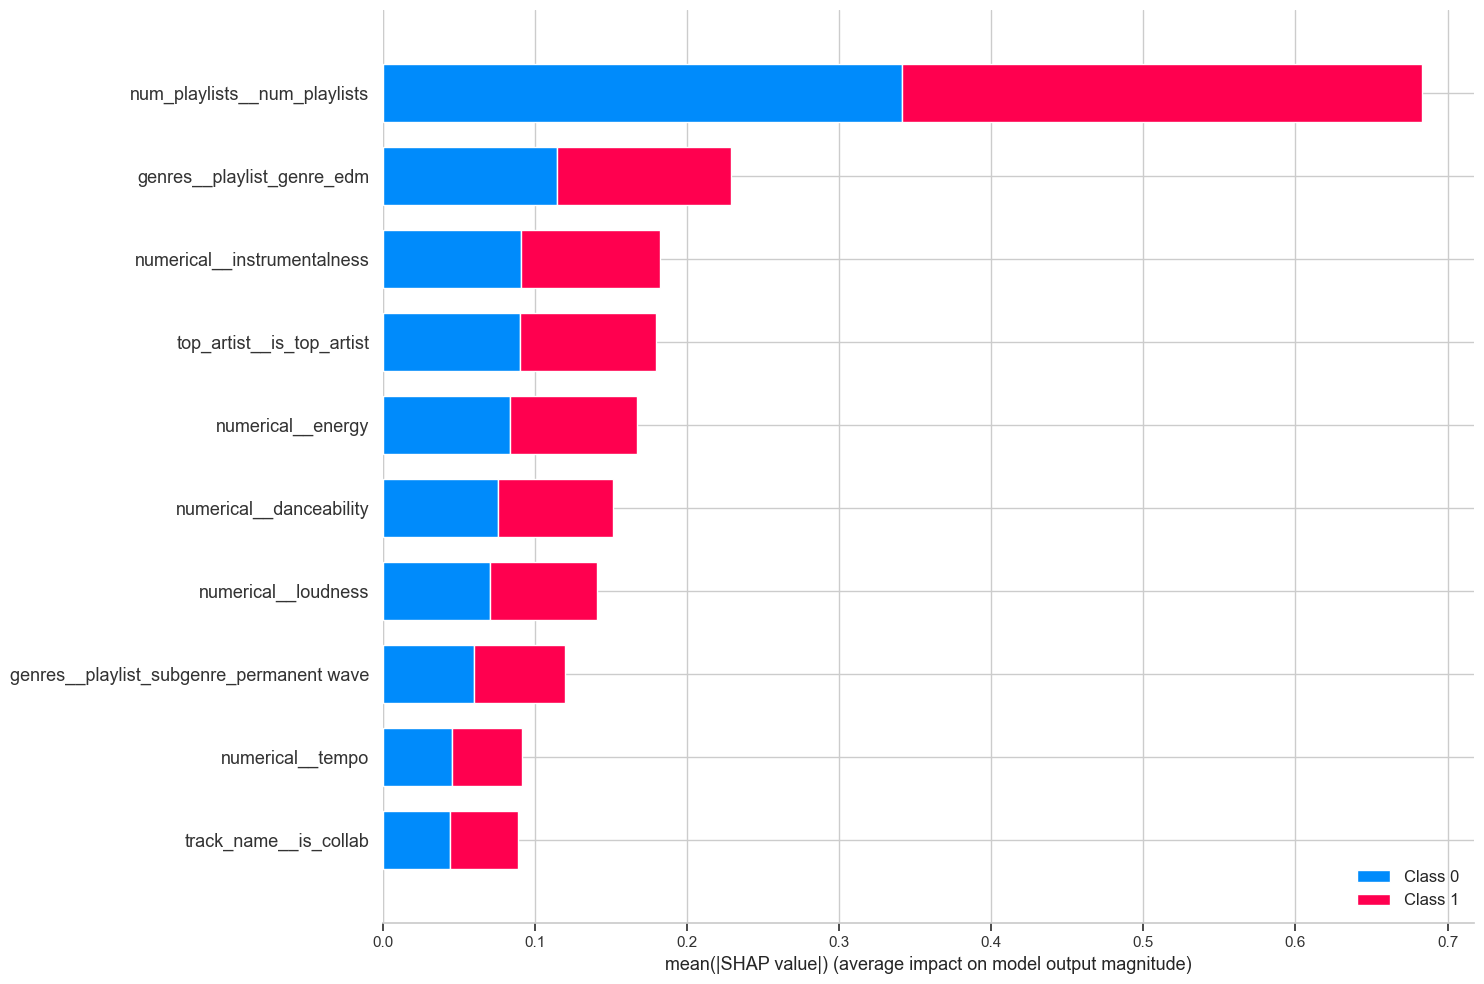

In [121]:
shap.summary_plot(
    shap_values,
    pd.DataFrame(
        shap.sample(
            X_test_transformed,
            50,
            random_state=42,
        ),
        columns=pipeline.named_steps["columntransformer"].get_feature_names_out(),
    ),
    title="SHAP Summary Plot",
    plot_type="bar",
    max_display=10,
    plot_size=(15, 10),
)
